In [1]:
! pip install super_image
! pip install datasets
! pip install torchmetrics

In [2]:
from super_image import CarnModel, ImageLoader
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchmetrics.functional import mean_squared_error
from torchmetrics.functional.image import peak_signal_noise_ratio
from PIL import Image
import torchvision.transforms as transforms
from super_image import CarnModel
from tqdm.notebook import tqdm

def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

SEED = 42
init_random_seed(SEED)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [4]:
class Div2KDataset(data.Dataset):
    def __init__(self):
        super(Div2KDataset, self).__init__()
        self.data_provider = load_dataset('eugenesiow/Div2k', 'bicubic_x4', split='train')
        self.transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32)])

    def __len__(self):
        return self.data_provider.num_rows

    def __getitem__(self, index):
        lr_image = Image.open(self.data_provider[index]['lr']).convert('RGB')
        hr_image = Image.open(self.data_provider[index]['hr']).convert('RGB')
        lr = self.transform(lr_image)
        hr = self.transform(hr_image)
        return lr, hr

dataset = Div2KDataset()
dataloader = data.DataLoader(dataset, batch_size=1)

#### Load pretrained CARN model from HuggingFace

In [5]:
model = CarnModel.from_pretrained('eugenesiow/carn', scale=4)
model = model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


https://huggingface.co/eugenesiow/carn/resolve/main/pytorch_model_4x.pt
1.591963 M parameters


#### 1. Check quality on DIV2K dataset

In [6]:
model.eval()
psnr_history = []
mse_history = []
for sample_i, (lr_img, hr_img) in enumerate(tqdm(dataloader, total=len(dataloader))):
    lr_img = lr_img.to(device)
    with torch.no_grad():
        sr_img_pred = model(lr_img).detach().cpu()
        psnr_history.append(peak_signal_noise_ratio(hr_img, sr_img_pred).item())
        mse_history.append(mean_squared_error(hr_img, sr_img_pred).item())
        del lr_img
        torch.cuda.empty_cache()

mean_psnr = np.mean(psnr_history)
std_psnr = np.std(psnr_history)
mean_mse = np.mean(mse_history)
std_mse = np.std(mse_history)
print(f'PSNR: mean={mean_psnr}, std={std_psnr}')
print(f'MSE: mean={mean_mse}, std={std_mse}')

  0%|          | 0/800 [00:00<?, ?it/s]

PSNR: mean=29.368758511543273, std=4.364113050116102
MSE: mean=0.0021861589092713983, std=0.0022505480408571664


#### 2. Apply style transfer methods to reduce encoded image error

In [7]:
def apply_style(model, lr_img, hr_img, max_optimizer_iter = 5):
    lr_img = lr_img.clone().to(device)
    hr_img = hr_img.clone().to(device)
    lr_img.requires_grad_(True)
    model.requires_grad_(False)
    model.eval()
    optimizer = optim.LBFGS([lr_img], max_iter=max_optimizer_iter)
    criterion = nn.MSELoss()
    sr_img_pred = None
    def closure():
        nonlocal sr_img_pred
        with torch.no_grad():
            lr_img.clamp_(0, 1)

        optimizer.zero_grad()
        sr_img_pred = model(lr_img)
        loss = criterion(sr_img_pred, hr_img)
        loss.backward()
        return loss

    optimizer.step(closure)
    return sr_img_pred.detach().cpu()

In [8]:
psnr_style_history = []
mse_style_history = []

for sample_i, (lr_img, hr_img) in enumerate(tqdm(dataloader, total=len(dataloader))):
    sr_img = apply_style(model, lr_img, hr_img)
    psnr_style_history.append(peak_signal_noise_ratio(hr_img, sr_img).item())
    mse_style_history.append(mean_squared_error(hr_img, sr_img).item())

mean_style_psnr = np.mean(psnr_style_history)
std_style_psnr = np.std(psnr_style_history)
mean_style_mse = np.mean(mse_style_history)
std_style_mse = np.std(mse_style_history)
print(f'PSNR Style: mean={mean_style_psnr}, std={std_style_psnr}')
print(f'MSE Style: mean={mean_style_mse}, std={std_style_mse}')

  0%|          | 0/800 [00:00<?, ?it/s]

PSNR Style: mean=29.968627467155457, std=4.20605719811624
MSE Style: mean=0.0018890501258874792, std=0.0019446523958142163


In [9]:
print(f'PSNR metric improved by {round((mean_style_psnr*100)/mean_psnr - 100, 2)}%')
print(f'MSE error reduced by {round((mean_style_mse*100)/mean_mse - 100, 2)}%')

PSNR metric improved by 2.04%
MSE error reduced by -13.59%


In [10]:
# Image Utils

def prepare_image(tensor):
    tensor = tensor.detach().cpu()
    ndarr = tensor[0].mul(255).clamp(0, 255).byte().permute(1, 2, 0).numpy()
    return ndarr

def save_image(tensor, filename):
    ndarr = prepare_image(tensor)
    im = Image.fromarray(ndarr)
    im.save(filename)

def scale_image_bilinear(tensor, scale):
    ndarr = prepare_image(tensor)
    img = Image.fromarray(ndarr).resize(tuple(element * scale for element in ndarr.shape[:-1]), resample=2)
    return np.array(img)

def box_image(ndarray, x, y, w, h):
    return ndarray[y:y+h, x:x+w, :]

def subplot_image(ax, ndarray, title):
    ax.imshow(ndarray, resample=False)
    ax.set_title(title, y=-0.1)
    ax.axis('off')

#### 3. Plot results

In [11]:
most_improved_sample_idx = (np.array(psnr_style_history) - np.array(psnr_history)).argmax().item()
lr_img, hr_img = dataset[most_improved_sample_idx]
lr_img = lr_img.to(device)
hr_img = hr_img.to(device)

sr_img_plain = model(lr_img.unsqueeze(0).contiguous()).detach().cpu()
sr_img_style = apply_style(model, lr_img.unsqueeze(0).contiguous(), hr_img.unsqueeze(0).contiguous(), max_optimizer_iter = 5)

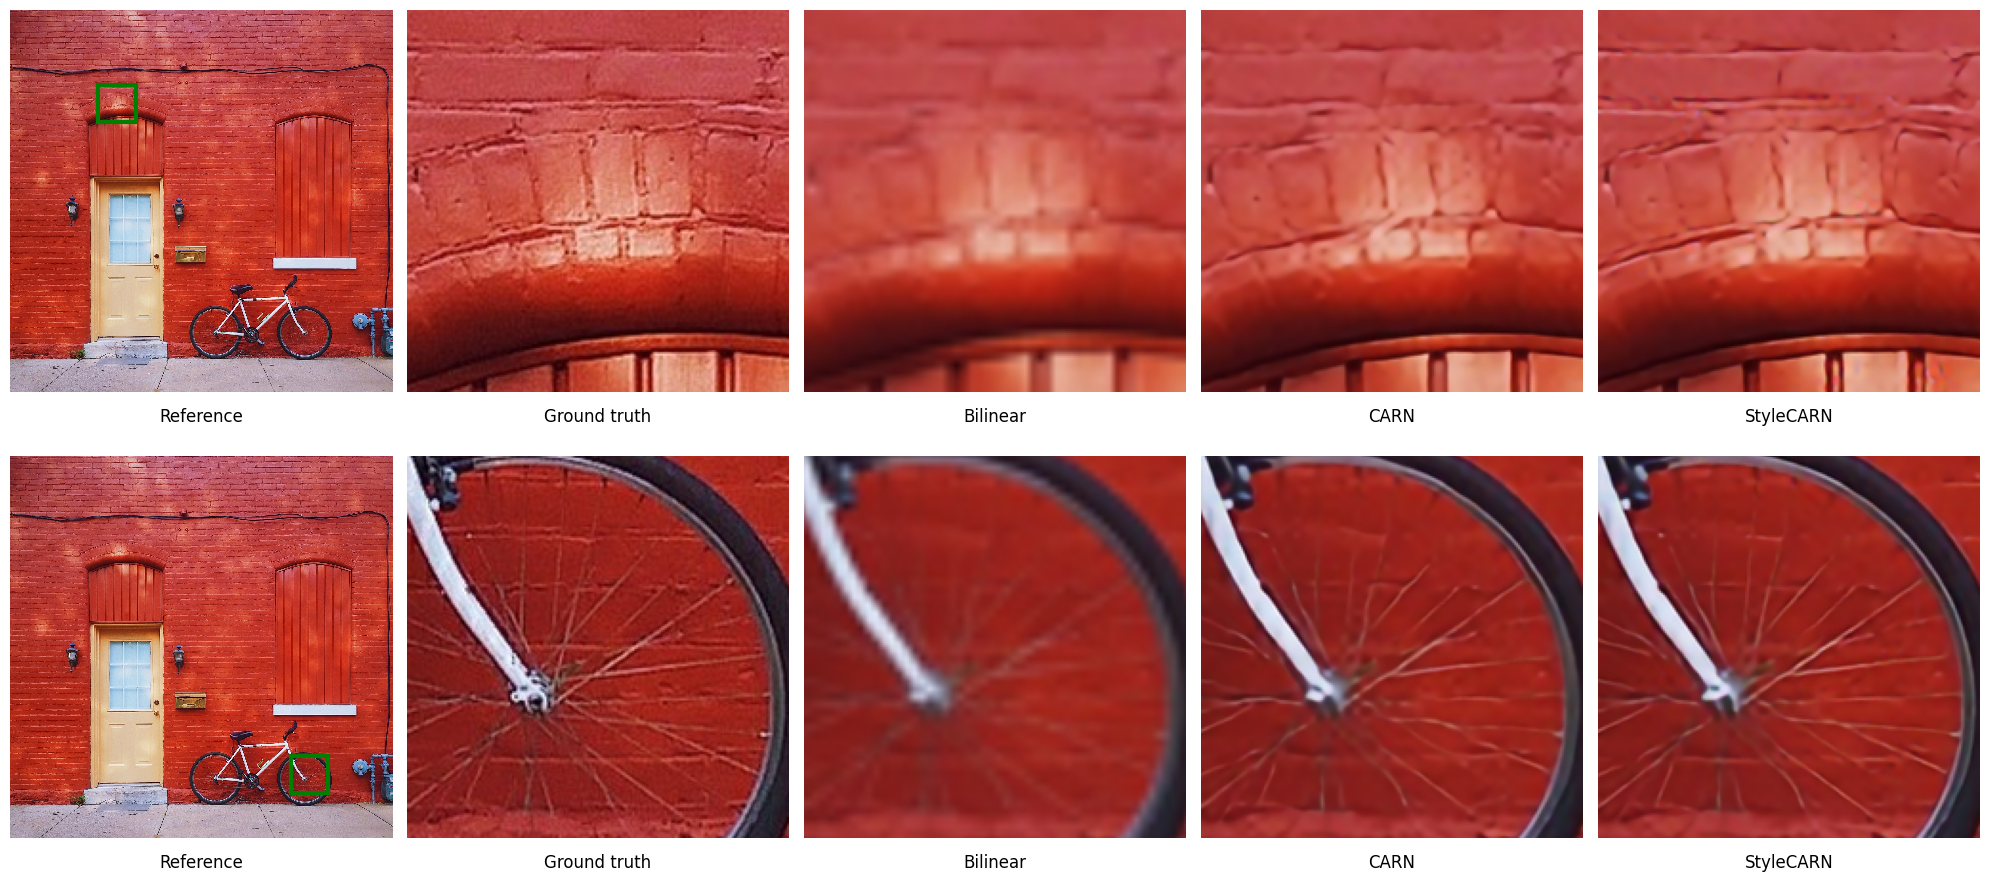

In [12]:
im_ground = prepare_image(hr_img.unsqueeze(0))
im_scale = scale_image_bilinear(lr_img.unsqueeze(0), scale = 4)
im_plain = prepare_image(sr_img_plain)
im_style = prepare_image(sr_img_style)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.set_tight_layout(True)
subplot_image(ax[0, 0], im_ground, 'Reference')
ax[0,0].add_patch(patches.Rectangle((470, 400), 200, 200, linewidth=3, edgecolor='g', facecolor='none'))
subplot_image(ax[0, 1], box_image(im_ground, x=470, y=400, w=200, h=200), 'Ground truth')
subplot_image(ax[0, 2], box_image(im_scale, x=470, y=400, w=200, h=200), 'Bilinear')
subplot_image(ax[0, 3], box_image(im_plain, x=470, y=400, w=200, h=200), 'CARN')
subplot_image(ax[0, 4], box_image(im_style, x=470, y=400, w=200, h=200), 'StyleCARN')

subplot_image(ax[1, 0], im_ground, 'Reference')
ax[1,0].add_patch(patches.Rectangle((1500, 1600), 200, 200, linewidth=3, edgecolor='g', facecolor='none'))
subplot_image(ax[1, 1], box_image(im_ground, x=1500, y=1600, w=200, h=200), 'Ground truth')
subplot_image(ax[1, 2], box_image(im_scale, x=1500, y=1600, w=200, h=200), 'Bilinear')
subplot_image(ax[1, 3], box_image(im_plain, x=1500, y=1600, w=200, h=200), 'CARN')
subplot_image(ax[1, 4], box_image(im_style, x=1500, y=1600, w=200, h=200), 'StyleCARN')

In [13]:
# np.save("psnr_history", np.array(psnr_history))
# np.save("mse_history", np.array(mse_history))
# np.save("psnr_style_history", np.array(psnr_style_history))
# np.save("mse_style_history", np.array(mse_style_history))

# psnr_history = np.load("psnr_history.npy")
# mse_history = np.load("mse_history.npy")
# psnr_style_history = np.load("psnr_style_history.npy")
# mse_style_history = np.load("mse_style_history.npy")